In [38]:
import numpy as np 
import os 
import matplotlib.pyplot as plt 
from astropy.table import Table, Column, join 
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
import scipy
from collections import Counter
from os.path import expanduser
import time
import datetime
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.signal import wiener
from scipy import signal
from astropy.io import fits
import glob
from scipy.signal import savgol_filter
from astropy.io import ascii 
from numpy.polynomial import Polynomial
from scipy.interpolate import splrep, sproot, splev
#from matplotlib import rc
#rc('font', **{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)
from sortedcontainers import SortedDict

In [39]:
#####################################################
############### FIND flare funcation  ###############
#####################################################
def FINDflare(flux, error, mjd_array,  N1=6, N2=1, N3=1, avg_std = False, std_window=7): 

    '''
    The algorithm for local changes due to flares defined by
    S. W. Chang et al. (2015), Eqn. 3a-d
    http://arxiv.org/abs/1510.01005
 
    Adpated code from jradavenport's appalossa for kepler flares. Adpated for DWF data with high 
    cadence and upperlimits for deep detections. 
    
    Parametres: 
    ---------------------------------------------------------------------------------------------
    flux:   numpy array
            data to search over
    error:	numpy array
            errors to corresponding data 
    N1: 	int, optional 
            Coefficient from original paper - default is 3
            How many times above thes stddev is requried.
    N2: 	int, optional 
            Coefficient from original paper - default is 1 
            How many times above the stddev and uncertanity is required 
            NOTE: May need to be tweaked to work with fainted magnitudes with higher uncerts. 
    N3: 	int, optional 
            coefficient form the original paper - default is 3 
            The number of consecutive points required to flare as a flare 
            NOTE: 2-3 is a reasonable number for DWF 
    avg_std: bool, optional 
            Should the sigma in this data be computed by the median of the rolling().std? (default is false)

    std_window: float, optional
                if avg_std = True, how big of a window should it use? 
                Default is 25 data points. 
                NOTE: DWF data may not have 25 data points for all detections. 

    Returns: 
    ---------------------------------------------------------------------------------------------
    '''

    #Find the Median value of the flux of the flare. IMPORTANT make sure that the flux is for ONE night ONLY for DWF 
    med_i = np.nanmedian(flux)
    #print(flux)
    #print('The median magnitude over lightcurve =' + str(med_i))

    if avg_std is False: 
        sig_i = np.nanstd(flux)  
        print('The standard deviation over the flux = : ' + str(sig_i))#the staddev of the window 
    else: 
        sig_i = np.nanmedian(pd.Series(flux).rolling(std_window).std())
    ca = flux - med_i

    cb = np.abs(flux-med_i)/sig_i 
    cc = np.abs(flux - med_i - error) / sig_i 

    ## Apply the cuts from eqn 3a-c
    #### because our flux's are
    ctmp = np.where((ca < 0) & (cb > N1) & (cc > N2))
    #ctmp = np.where((cb > N1))
    cindx = np.zeros_like(flux)
    cindx[ctmp] = 1 
    #print(cindx) 
    

    # need to find cumulative number of points that pass ctmp 
    # Count in reverse 
    
    ConM = np.zeros_like(flux)
    # this requires a full pass thrus the data -> bottleneck 
    for k in range(2, len(flux)):
        ConM[-k]= cindx[-k]*(ConM[-(k-1)] + cindx[-k] )
    
    #print('Flare event detected in array at points, descending count from start point to finish point: ' + str(ConM))

    #these only defined between dl[i] and dr[i] 
    # find flare start where values in ConM switch from 0 to >=N3 
    istart_i = np.where((ConM[1:] >= N3)& (ConM[0:-1] - ConM[1:] <0))[0] +1 
    print('Flare begins on point: ' + str(istart_i))
    #print( istart_i)
    #Use the value of ConM to determine how many points away stop is 

    istop_i = istart_i + (ConM[istart_i] -1)
    istart_i = np.array(istart_i, dtype = 'int') 
    istop_i = np.array(istop_i, dtype = 'int') 
    print('Flare stops on point: ' + str(istop_i))
    
    
    min_day = np.min(mjd_array)
    sum_of_points = np.sum(ConM)
    #print('sum of ConM : ' + str(sum_of_points))
    
    return istart_i, istop_i, sum_of_points, 

In [40]:
#####################################################
####### Error bar filled plot funcation  ############
#####################################################
def errorfill(x, y, yerr, color=None, alpha_fill=0.2, ax=None, Label1=None, Label2=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill, label = str(Label2))
    

In [41]:
###################################
####### FWHM Funcation ############
###################################
def fwhm(x, y, k=5):
    """
    Determine full-with-half-maximum of a peaked set of points, x and y.

    Assumes that there is only one peak present in the datasset.  The function
    uses a spline interpolation of order k.
    """

    half_max = np.max(y)/2.0
    print(half_max)
    newy = y - half_max
    plt.plot(x, newy)
    s = splrep(x, y - half_max, k=k)
    roots = sproot(s)
    print(roots)
    if len(roots) > 2:
        raise MultiplePeaks("The dataset appears to have multiple peaks, and "
                "thus the FWHM can't be determined.")
    elif len(roots) < 2:
        raise NoPeaksFound("No proper peaks were found in the data set; likely "
                "the dataset is flat (e.g. all zeros).")
    else:
        return roots[0], roots[1]

# Step 1: Make sure your light curve is in time series order 
 Resave file with same file name so it only need to be done once as a precaution 


In [42]:
filename = "DWF040239.269-545106.763_150116"
path = '/Volumes/SaraWSSD/gaia_500pc_searches/flares/ascii_files/2018_Dusty10/'+filename
print(path)
mjd, mag, emag, ulim = np.loadtxt(path, unpack =True, skiprows=1)
mydict = SortedDict()
for j in range(len(mag)):
    mydict[mjd[j]] = mjd[j], mag[j],emag[j], ulim[j] 

mjd_sorted = []
mag_sorted = []
emag_sorted = []
ulim_sorted = []

for key, values in mydict.items():
    mjd_sorted.append(values[0])
    mag_sorted.append(values[1])
    emag_sorted.append(values[2])
    ulim_sorted.append(values[3])

info = Table()
info['mjd'] = mjd_sorted
info['mag'] = mag_sorted
info['emag'] = emag_sorted
info['ulim'] = ulim_sorted
print(info)
output = path
info.write(output, format='ascii', overwrite = True)

/Volumes/SaraWSSD/gaia_500pc_searches/flares/ascii_files/2018_Dusty10/DWF040239.269-545106.763_150116
     mjd              mag                 emag               ulim       
-------------- ------------------ ------------------- ------------------
57374.20037983                0.0                 0.0 22.190732136555297
57374.20094389                0.0                 0.0 22.395380748643806
57374.20150237                0.0                 0.0 22.213165830862497
57374.20205536                0.0                 0.0 22.201854134715052
57374.20259987                0.0                 0.0 22.162902064012865
57374.20314443                0.0                 0.0  22.18348130735643
57374.20369541                0.0                 0.0 22.224478118988873
57374.20425221                0.0                 0.0 22.191057873774348
57374.20480231  22.67300033569336 0.20499999821186066                0.0
57374.20535961                0.0                 0.0  22.43182028905287
           ...        

# Step 2: Look at flare in detail using FINDflare


Flare begins on point: [66]
Flare stops on point: [118]
Median Mag: 15.710999965667725
Median eMag: 0.0020000000949949026
STD of mags: 0.01224042356662331
Change in mag: 0.4850001335144043
flare time (sec): 2584.01404756587
DWF080943.768-775051.105_180606


Text(0.5, 1.0, 'DWF080943.768-775051.105_180606')

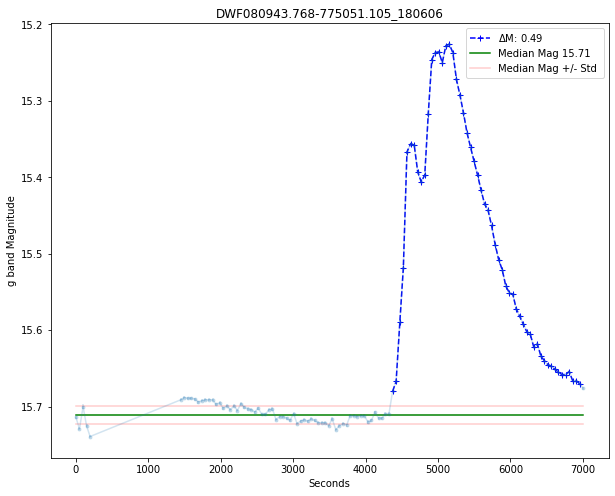

In [43]:
######################################################################
####### select either orignal file or twice the distance light curve 
######################################################################

### FOR Double the distance ###
#filename = "DWF080943.768-775051.105_180606" + "_twice_distance.ascii"
#path = '/Volumes/SaraWSSD/gaia_500pc_searches/flare_sample_full/flares_double_distance_away/'+filename
#mjd, mag, emag = np.loadtxt(path, unpack =True, skiprows=1)
### FOR Double the distance ###

### FOR original LC ###
filename = 'DWF080943.768-775051.105_180606'
path = '/Volumes/SaraWSSD/gaia_500pc_searches/flare_sample_full/lc_file/'+filename
mjd, mag, emag, ulim = np.loadtxt(path, unpack =True, skiprows=1)
### FOR original LC ###


clean_mag = []
clean_emag = []
clean_mjd = []

for i, j,z in zip(mjd ,mag, emag):
    if j != 0:
        clean_mag.append(j)
        clean_emag.append(z)
        clean_mjd.append(i)

mjd_sec = []
for i in clean_mjd:
    new = ((i-min(mjd))*24)*60*60
    mjd_sec.append(new)

upperlim_mjd_sec = []
upperlim_mag_sec = []
for i, j in zip(mjd ,ulim):
    if j != 0:
        new = ((i-min(mjd))*24)*60*60
        upperlim_mjd_sec.append(new)
        upperlim_mag_sec.append(j)

        
### Run lightcurve through FINDflare ###        
istart_i, istop_i, sum_of_points = FINDflare(clean_mag, clean_emag, clean_mjd,  N1=3, N2=2, N3=2, avg_std = True, std_window=3)


##############################################################
####### Leave as below for single flares, need 
####### Change for flares with multiple peaks, or flares in a single lightcurve
##############################################################
flare_number = 0
flare_end_num =1
# if you want to caluclate the median magnitude before or after the flare event
before_after = 'before'
##############################################################


plt.figure(figsize=(10, 8))
flare = istart_i[flare_number] 
flare_stop =  istop_i[flare_number]+flare_end_num

if before_after == 'before':
    med_mag = np.median(clean_mag[:flare])
    med_emag = np.median(clean_emag[:flare])
elif  before_after == 'after':
    med_mag = np.median(clean_mag[flare_stop:])
    med_emag = np.median(clean_emag[flare_stop:])
    
medians = []
for x in clean_mag:
    medians.append(med_mag)
mean = np.mean(clean_mag)

means = []
for x in clean_mag:
    means.append(mean)

if before_after == 'before':
    std = np.std(clean_mag[:flare])
elif  before_after == 'after':
    std = np.std(clean_mag[flare_stop:])

print('Median Mag: '+ str(med_mag))
print('Median eMag: '+ str(med_emag))
print('STD of mags: '+ str( std))

peak_mag = min(clean_mag)
mag_change = med_mag - peak_mag
print('Change in mag: ' + str(mag_change))
peak_idx = flare
peak_mag = clean_mag[peak_idx]
peak_mag_mjd = mjd_sec[peak_idx]

flare_begin_mjd = mjd_sec[peak_idx]
flare_begin_mag = clean_mag[peak_idx]
flare_end_mjd = mjd_sec[flare_stop]
flare_end_mag = clean_mag[flare_stop]
flare_mjd = mjd_sec[peak_idx-1:flare_stop]
flare_mag = clean_mag[peak_idx-1:flare_stop]
flare_time = flare_end_mjd -flare_begin_mjd
print('flare time (sec): ' + str(flare_time))


plt.errorbar(mjd_sec, clean_mag, yerr=clean_emag, fmt='.-', alpha=0.2)
#plt.plot(upperlim_mjd_sec, upperlim_mag_sec, '^r', alpha=0.5)
plt.plot(flare_mjd,flare_mag,'b+--', label = "$\Delta$M: " + str(round(mag_change,2)))
plt.plot(mjd_sec,medians , 'g', label='Median Mag '+str(round(med_mag, 2)))
plt.plot(mjd_sec,medians + std , 'r',  alpha=0.2,label='Median Mag +/- Std ' )
plt.plot(mjd_sec,medians -std , 'r', alpha=0.2)

plt.xlabel('Seconds')
plt.ylabel('g band Magnitude')
print(filename)
#plt.plot(peak_mag_mjd, peak_mag, 'b', )
plt.gca().invert_yaxis()
#plt.legend(bbox_to_anchor=(0.0,1))
plt.legend()
plt.title(filename)
###################### If you want to save image ################
#plt.savefig('/Volumes/SaraWSSD/gaia_500pc_searches/flare_sample_full/plots_double_distance/'+filename+'_flareplot_'+str(flare_number)+'.png')
#plt.savefig('/Volumes/SaraWSSD/gaia_100pc_searches/flare_sample_full_flares/flare_plots/'+filename+'_flareplot_'+str(flare_number)+'.png')

# Step 3: Calculate realative intensity for all points

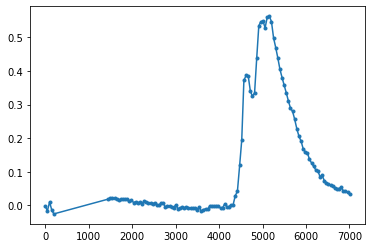

In [44]:
int_point = []
int_error = []
for i, j in zip(clean_mag, clean_emag):
    deltam = i - med_mag
    ints= 10**(deltam/(-2.5))
    int_point.append(ints)
    deltam_error = med_mag -j
    #print(deltam_error)
    ints_error = 10**(deltam_error/(-2.5))
    #print(ints_error)
    int_error.append(ints_error)

int_point_zero = []
for i in int_point:
    int_point_zero.append(i-1)
plt.errorbar(mjd_sec,int_point_zero, yerr=int_error, marker='.')

info = Table()
info['mjd'] = mjd_sec
info['intensity_norm_to_one'] = int_point
info['intensity_norm_to_zero'] = int_point_zero

## Save file ## 
#output = '/Volumes/SaraWSSD/gaia_500pc_searches/flare_sample_full/int_lc_file/'+filename+ '_rel_intensity.ascii'
#print(output)
#info.write(output, format='ascii', overwrite = True)

# Step 4: Calculate total rel intensity 

Flare begins on point: [20]
Flare stops on point: [21]
[1.00184451 1.03752747 1.0289637  1.00554198]
DWF103337.011-350837.054_170203
Total flare output normalised 1: 4.073877664767897
Total flare output normalised 0: 0.07387766476789714


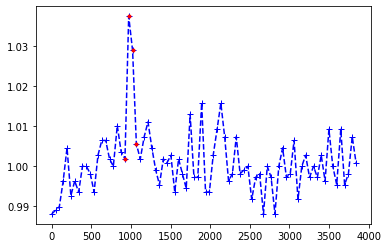

In [45]:
filename = 'DWF103337.011-350837.054_170203'
name = filename
filename_int = name+'_rel_intensity.ascii'
path = '/Volumes/SaraWSSD/gaia_500pc_searches/flare_sample_full/int_lc_file/'+filename_int
mjd_secs, rel_flux = np.loadtxt(path, unpack =True, skiprows=1)
#rel_flux_err
filename = name
path = '/Volumes/SaraWSSD/gaia_500pc_searches/flare_sample_full/lc_file/'+filename
mjd, mag, emag, uplim = np.loadtxt(path, unpack =True, skiprows=1)

clean_mag = []
clean_emag = []
clean_mjd = []

for i, j,z in zip(mjd ,mag, emag):
    if j != 0:
        clean_mag.append(j)
        clean_emag.append(z)
        clean_mjd.append(i)

#istart_i, istop_i, sum_of_points = FINDflare(mag, emag, mjd,  N1=1, N2=0, N3=0, avg_std = True, std_window=3)
istart_i, istop_i, sum_of_points = FINDflare(clean_mag, clean_emag, clean_mjd,  N1=3, N2=2, N3=2, avg_std = True, std_window=3)
#istart_i, istop_i, sum_of_points = FINDflare(mag, emag, mjd,  N1=3, N2=0, N3=0, avg_std = True, std_window=3)

flare = istart_i[0]-1
flare_stop =  istop_i[0]+2
peak_idx = flare

flare_time = mjd_secs[peak_idx:flare_stop]
flare_rel = rel_flux[peak_idx:flare_stop]
#flare_rel_err = rel_flux_err[peak_idx:flare_stop]
print(flare_rel)
#flare_time = mjd_secs[-3:len(mjd_secs)]
#flare_rel = rel_flux[-3:len(mjd_secs)]
plt.plot(mjd_secs, rel_flux, 'b+--')
plt.plot(flare_time, flare_rel, 'r.' )
#plt.ylim(0.9, 1.2)
print(filename)

zero_rel = flare_rel-1
#zero_rel_err = flare_rel_err
print('Total flare output normalised 1: ' +str(sum(flare_rel)))
print('Total flare output normalised 0: ' +str(sum(zero_rel)))
#print('Total flare output error normalised 0: ' +str(sum(zero_rel_err)))